<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-steps" data-toc-modified-id="First-steps-1">First steps</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Creating-the-environment" data-toc-modified-id="Creating-the-environment-1.2">Creating the environment</a></span></li><li><span><a href="#Learning-to-use-the-environment" data-toc-modified-id="Learning-to-use-the-environment-1.3">Learning to use the environment</a></span></li><li><span><a href="#Playing-and-recording-the-games" data-toc-modified-id="Playing-and-recording-the-games-1.4">Playing and recording the games</a></span></li><li><span><a href="#Learning-from-recorded-games" data-toc-modified-id="Learning-from-recorded-games-1.5">Learning from recorded games</a></span><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.5.1">Preparing the data</a></span></li><li><span><a href="#Creating-the-model" data-toc-modified-id="Creating-the-model-1.5.2">Creating the model</a></span><ul class="toc-item"><li><span><a href="#Problems-with-conda-environment" data-toc-modified-id="Problems-with-conda-environment-1.5.2.1">Problems with conda environment</a></span></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-1.5.2.2">Building the model</a></span></li></ul></li></ul></li><li><span><a href="#Visualizing-agent-play" data-toc-modified-id="Visualizing-agent-play-1.6">Visualizing agent play</a></span></li></ul></li></ul></div>

# First steps

On this notebook I want to learn how to use the arena on python and how to train a model.

## Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import glob
from sklearn.preprocessing import OneHotEncoder

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig

## Creating the environment

In [2]:
env = UnityEnvironment(
    file_name='/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/env/AnimalAI.x86_64',   # Path to the environment
    worker_id=1,                # Unique ID for running the environment (used for connection)
    seed=0,                     # The random seed 
    docker_training=False,      # Whether or not you are training inside a docker
    n_arenas=1,                 # Number of arenas in your environment
    play=False,                 # Set to False for training
    inference=False,            # Set to true to watch your agent in action
    resolution=None             # Int: resolution of the agent's square camera (in [4,512], default 84)
)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1


In [3]:
arena_config = ArenaConfig('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/examples/configs/1-Food.yaml')
env.reset(arenas_configurations=arena_config, train_mode=True)

{'Learner': <animalai.envs.brain.BrainInfo at 0x7fd4bed1cef0>}

## Learning to use the environment

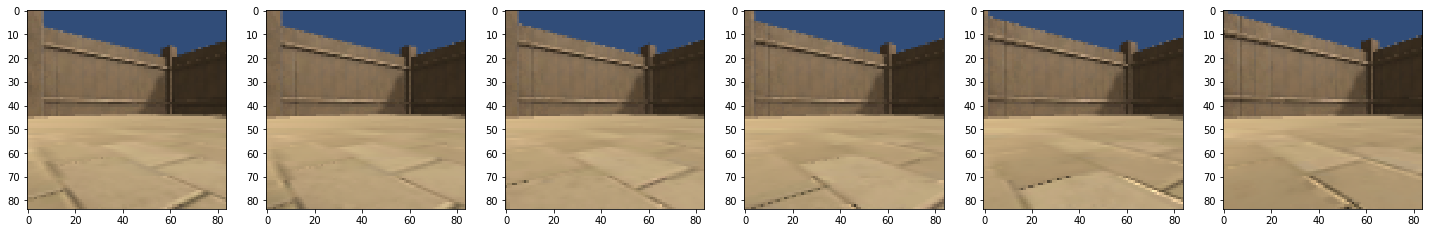

In [4]:
plt.figure(figsize=(25, 5))
for i in range(6):
    plt.subplot(1, 6, i+1)
    info = env.step(vector_action=[1, 0])
    plt.imshow(info['Learner'].visual_observations[0][0]);

In [5]:
env.reset()
for _ in tqdm(range(1000)):
    info = env.step(vector_action=[0, 1])

With this configuration the environment is capable of doing about 300 iterations per second, that is quite fast.

## Playing and recording the games

I will always turn right (press d) by default. When playing depending on the start orientation it didn't felt natural to do that, sometimes I think is better to turn left. In just 10 minutes I'm able to play more than 50 games, so this is a very fast process.

In [4]:
def get_action_from_keyboard():
    key_to_action = {
        ord('d'): [0, 1],
        ord('a'): [0, 2],
        ord('w'): [1, 0],
        ord('s'): [2, 0],
        ord('o'): None,
    }
    while 1:
        key = cv2.waitKey()
        if key in key_to_action:
            action = key_to_action[key]
            break
        else:
            print('Unknown key pressed')
    return action

In [5]:
class LevelStorage():
    def __init__(self):
        self.frame = []
        self.speed = []
        self.previous_action = []
        self.action = []
    
    def add(self, frame, speed, previous_action, action):
        self.frame.append(frame)
        self.speed.append(speed)
        self.previous_action.append(previous_action)
        self.action.append(action)
        
    def save(self, path):
        np.savez(path, frame=self.frame, speed=self.speed, previous_action=self.previous_action, action=self.action)

In [8]:
info = env.reset()['Learner']
level_idx = 0
n_steps = 0
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
level_storage = LevelStorage()

while 1:
    frame = info.visual_observations[0][0]
    speed = info.vector_observations.round(2)
    previous_action = info.previous_vector_actions
    
    cv2.imshow('img', frame[:, :, [2, 1, 0]])
    msg = 'Level: %i     n_steps: %i   Reward: %.2f   Speed: %s Text observations: %s' % (
        level_idx,
        n_steps,
        info.rewards[0],
        speed,
        info.text_observations[0])
    cv2.displayOverlay('img', msg)
    action = get_action_from_keyboard()
    if action is None:
        break
        
    level_storage.add(frame, speed, previous_action, action)
    
    info = env.step(vector_action=action)['Learner']
    n_steps += 1
    is_level_ended = info.max_reached[0] or info.local_done[0]
    if is_level_ended:
        level_idx += 1
        n_steps = 0
        level_storage.save('/media/guillermo/Data/Kaggle/animalai/gameplay/1_food/%03d.npz' % level_idx)
        level_storage = LevelStorage()
        
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Learning from recorded games

I have recorded 53 games that use less than 500 MB of memory. That is about 10 MB per game.

I want to train a model that learns to play like me. As input I will use:

* pixels
* speed
* last action

I will process the pixels with a lenet-like network and finally use a perceptron to predict the probability over each action.

For training I will leave some of the games out for validation.

### Preparing the data

In [6]:
game_filepaths = sorted(glob.glob('/media/guillermo/Data/Kaggle/animalai/gameplay/1_food/*.npz'))
len(game_filepaths)

53

In [30]:
def load_games_data(game_filepaths):
    data = [np.load(game_filepath) for game_filepath in tqdm(game_filepaths, desc='Loading recorded games')]
    ohe = OneHotEncoder(categories=[range(3)], sparse=False)
    previous_action = np.concatenate([game['previous_action'] for game in data], axis=0)[:, 0]
    ohe.fit(previous_action[:, 1:2])
    previous_action = [ohe.transform(previous_action[:, 0:1]), ohe.transform(previous_action[:, 1:2])]
    previous_action = np.concatenate([np.zeros((2437, 3)), np.zeros((2437, 3))], axis=1)
    model_input = {
        'frame': np.concatenate([game['frame'] for game in data], axis=0),
        'speed': np.concatenate([game['speed'] for game in data], axis=0)[:, 0],
        'previous_action': previous_action,
    }
    action = np.concatenate([game['action'] for game in data], axis=0)
    model_output = {
        'action_move': ohe.transform(action[:, 0:1]),
        'action_rotate': ohe.transform(action[:, 1:2]),
    }
    return model_input, model_output, data

In [33]:
model_input, model_output, data = load_games_data(game_filepaths)
input_keys = ['frame', 'speed', 'previous_action']
output_keys = ['action_move', 'action_rotate']
print('Inputs')
for key in input_keys:
    print('%s shape: %s' % (key, str(model_input[key].shape)))
print('Outputs')
for key in output_keys:
    print('%s shape: %s' % (key, str(model_output[key].shape)))


Inputs
frame shape: (2437, 84, 84, 3)
speed shape: (2437, 3)
previous_action shape: (2437, 6)
Outputs
action_move shape: (2437, 3)
action_rotate shape: (2437, 3)


In [34]:
train = load_games_data(game_filepaths[:-10])
val = load_games_data(game_filepaths[-10:])
print('Number of train samples: %i' % len(train[0]['frame']))
print('Number of validation samples: %i' % len(val[0]['frame']))


Number of train samples: 1957
Number of validation samples: 480


### Creating the model

The idea is to process the frame using a lenet like network and merge it later with speed and previous move to take a decision over the actions.

![](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)

#### Problems with conda environment

There are inconsistencies between opencv, tensorflow-gpu and the environment requirements (numpy 1.14.5). Maybe I should create an environment for playing an another for training. However if I want to do reinforcement learning I need both in the environment.

Which are my requirements:
* python 3.6, this is required by animalai
* opencv 4.1.0 or higher, previous versions do not show the window
* tensorflow-gpu, needed to train
* numpy 1.14.5, is this really necessary?

I think the problem is that there are conflicts between them.

Ideas:
* I could try to create an environment from zero
* Why numpy 1.14.5 is needed?

#### Building the model

## Visualizing agent play